# tensorflow pistachio
Tuning with hyperopt

## Links
  - [notes on training/validation loss](https://siddiqueabusaleh.medium.com/why-my-training-loss-is-higher-than-validation-loss-is-the-reported-loss-even-accurate-8843e14a0756)
  - [initialisation values](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)
  - [shap feature importance](https://shap.readthedocs.io/en/latest/tabular_examples.html#neural-networks)

In [1]:
import tensorflow as tf
print(tf.__version__)

2024-11-30 02:51:43.187280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1


## arff to csv





In [ ]:
import pandas as pd 
from scipy.io import arff
import os 

from pistachio.data import load_arff_file

label_mapping = {'Kirmizi_Pistachio': 0, 'Siit_Pistachio': 1}


arff_filename = './data/Pistachio_16_Features_Dataset.arff'
csv_filename = './data/pistachio_16.csv'

if not os.path.exists(csv_filename):
    df = load_arff_file(arff_filename, label_mapping)
    df.head()
    df.to_csv(csv_filename, index=False, header=True)
    print(f'wrote file to {csv_filename}')
else:
    print(f'{csv_filename} exists')


./data/pistachio_16.csv exists


In [3]:
## Parameters

In [ ]:


# dataset
# BATCH_SIZE = 16 
# PREFETCH = tf.data.AUTOTUNE
SEED=37

# model parameters
# UNITS = 12
# LAYER_1_L1 = 2e-4
# LAYER_1_L2 = 5e-3
# LAYER_2_L1 = 2e-4
# LAYER_2_L2 = 5e-3



#model fitting
# EPOCHS = 500
# LEARNING_RATE = 0.001 # initial learning rate
# LR_PLATEAU_FACTOR = 0.5
# LR_PLATEAU_PATIENCE = 5
# LR_DECAY_RATE = 0.8
# MIN_LEARNING_RATE = 1e-6
# EARLY_STOPPING_PATIENCE = 40


# mlflow
MLFLOW_URI = uri="http://pistachio_mlflow:5000"
MLFLOW_EXPERIMENT = "pistachio_tf_tuning"
MLFLOW_RUN_DESCRIPTION = 'initial tuning of two layer model'
MLFLOW_TAGS = {'architecture': f'two layers, {UNITS} units'}

# hyperopt
TRIALS_FILE_LOCATION = f'./trials/trials_{MLFLOW_EXPERIMENT}.pkl'
# will save trials object at this location
TRIALS_PER_RUN = 5
# run this many trials per notebook execution.




## dataset


In [ ]:
from pistachio.data import read_or_generate_splits

# define where train/test csvs will live
split_data_path = f"./data/seed_{SEED}/"
if not os.path.exists(split_data_path):
    os.makedirs(split_data_path)

train_df, valid_df, test_df = read_or_generate_splits(split_data_path, csv_filename, seed=SEED)

for setname, df in zip(['train','validation','test'],[train_df, valid_df, test_df]):
    print(setname)
    print(f'df shape = {df.shape}')
    agged = df.groupby('Class').agg({'AREA':'count'}).reset_index()
    print(agged)


train
df shape = (1288, 17)
   Class  AREA
0      0   738
1      1   550
validation
df shape = (430, 17)
   Class  AREA
0      0   247
1      1   183
test
df shape = (430, 17)
   Class  AREA
0      0   247
1      1   183


In [7]:
feature_columns = list(train_df.columns)
feature_columns.remove('Class')
feature_columns

['AREA',
 'PERIMETER',
 'MAJOR_AXIS',
 'MINOR_AXIS',
 'ECCENTRICITY',
 'EQDIASQ',
 'SOLIDITY',
 'CONVEX_AREA',
 'EXTENT',
 'ASPECT_RATIO',
 'ROUNDNESS',
 'COMPACTNESS',
 'SHAPEFACTOR_1',
 'SHAPEFACTOR_2',
 'SHAPEFACTOR_3',
 'SHAPEFACTOR_4']

In [ ]:
# from pistachio.data import df_to_dataset
# # create datasets
# train_ds = df_to_dataset(train_df,'Class', shuffle=True, drop=True)
# valid_ds = df_to_dataset(valid_df,'Class', shuffle=False, drop=False)
# test_ds = df_to_dataset(test_df,'Class', shuffle=False, drop=False)

2024-11-30 02:51:45.701279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 02:51:45.710273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 02:51:45.710540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
from hyperopt import hp
# hyperopt search space/parameters
hp_space = {
    # model
    'units': hp.randint('units', 5,12),
    'layer_l1_reg': hp.loguniform('layer_l1_reg', 2e-6,2e-3),
    'layer_l2_reg':hp.loguniform('layer_l2_reg', 2e-6,2e-3),
    'feature_columns':feature_columns,
    # fitting
    'learning_rate': hp.loguniform('learnig_rate', 1e-7,5e-3),
    'lr_plateau_factor': hp.uniform('lr_plateau_factor', 0.5, 0.95),
    'lr_plateau_patience': 20,
    'lr_decay_rate': 0.9,
    'min_learning_rate': 5e-8,
    'early_stopping_patience': 40,

    # data/batch/epochs
    'batch_size': 16,
    'prefetch':  tf.data.AUTOTUNE,
    'epochs': 500,
    'seed':SEED
}


train: {'0': 734, '1': 546, 'proportion_0': 0.5734375, 'proportion_1': 0.4265625}
valid: {'0': 247, '1': 183, 'proportion_0': 0.5744186046511628, 'proportion_1': 0.4255813953488372}
test: {'0': 247, '1': 183, 'proportion_0': 0.5744186046511628, 'proportion_1': 0.4255813953488372}


In [ ]:
from pistachio.data import df_to_dataset
from pistachio.model import get_pistachio_model
from typing import Dict 
import mlflow
# create datasets
import mlflow
import seaborn as sns
import numpy as np

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve

from pistachio.evaluation import plot_metric, get_roc_results, plot_roc_curve, get_confusion_matrix
from pistachio.evaluation import make_precision_recall_plot, make_prob_calibration_plot, make_confusion_matrix_plot
sns.set()



mlflow.set_tracking_uri(uri=MLFLOW_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)

# define our hyperopt objective
def pistachio_objective(**kwargs) ->Dict:
    '''take model parameters, build, train and evaluate model, return loss value and other stats'''
    
    # reset tf state
    tf.keras.backend.clear_session()

    # start mlflow run
    with  mlflow.start_run(tags=MLFLOW_TAGS, description=MLFLOW_RUN_DESCRIPTION) as mlflow_run:

        run_name = mlflow_run.info.run_name
        run_id = mlflow_run.info.run_id
        mlflow.log_params(kwargs)


        # define datasets 
        # think these need to go in here, given that we're clearing the tf state
        train_ds = df_to_dataset(
            train_df,
            'Class',
            shuffle=True,
            drop=True,
            batch_size=kwargs.get('batch_size',32),
            prefetch=kwargs.get('prefetch', 32))

        valid_ds = df_to_dataset(
            valid_df,
            'Class', 
            shuffle=False,
            drop=False,
            batch_size=kwargs.get('batch_size',32),
            prefetch=kwargs.get('prefetch', 32))
        
        # get the model we'll train, adapting it on train data
        model = get_pistachio_model(
            feature_columns=feature_columns,
            units=kwargs.get('units',10),
            layer_l1_reg=kwargs.get('layer_l1_reg',0.0),
            layer_l2_reg=kwargs.get('layer_l2_reg',0.0))
    
        checkpoint_dir = './pistachio_model_checkpoints/'
        checkpoint_path = os.path.join(checkpoint_dir, run_name)
        os.makedirs(checkpoint_path, exist_ok=True)

        metrics = {
        'predicted_probability': [
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.BinaryAccuracy()]}

        callbacks = [
            # tf.keras.callbacks.TensorBoard(logdir, update_freq='batch'),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=kwargs.get('lr_plateau_factor'), 
                patience=kwargs.get('lr_plateau_patience'), 
                min_lr=kwargs.get('min_learning_rate')),
            tf.keras.callbacks.EarlyStopping(patience=kwargs.get()),
            # checkpoint
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor='val_loss',
                mode='min',
                initial_value_threshold=0.7,
                save_best_only=True),
            # mlflow
            mlflow.keras.MlflowCallback(mlflow_run)]
    
        optimizer = tf.keras.optimizers.Adam(learning_rate=kwargs.get('learning_rate'))

        # compile model
        model.compile(
            optimizer=optimizer,
            loss={'predicted_probability': tf.keras.losses.BinaryCrossentropy(from_logits=False)},
            metrics=metrics)
        
        # train model
        history = model.fit(
            train_ds,
            epochs=kwargs.get('epochs'),
            callbacks=callbacks,
            validation_data=valid_ds)
        
        history_df = pd.DataFrame(history.history)
        history_df['epoch'] = history_df.index
        # history_df.columns

        # plot training stuff
        plot_dir = f'./plots/{run_name}/'
        os.makedirs(plot_dir, exist_ok=True)
        metrics_to_plot = [
            'learning_rate',
            'auc',
            'loss',
            'binary_accuracy',
            'recall',
            'precision']

        metric_plots = {}
        for mm in metrics_to_plot:
            metric_plots[mm] = plot_metric(history_df, mm);
            fig_path = os.path.join(plot_dir, f'{mm}_vs_epoch.png');
            print(fig_path)
            metric_plots[mm][0].savefig(fig_path);
        
        # look at the best training epoch, get some metrics

        val_metrics = [k for k in history_df.columns if k.startswith('val')]
        best_epoch = history_df.loc[history_df.val_loss == np.min(history_df.val_loss)][['epoch'] + val_metrics].copy()

        # best_epoch
        rename = {k:f'best_epoch_{k}' for k in val_metrics}
        rename['epoch'] = 'best_epoch'

        best_stats = best_epoch\
            .rename(columns=rename)\
            .to_dict(orient='records')[0]
        
        # log these things
        mlflow.log_artifacts(plot_dir, artifact_path='training_plots')
        mlflow.log_metrics(best_stats)

        # load the best version of the model
        model = tf.keras.models.load_model(checkpoint_path)
        # get predictions on validation set
        valid_features = {k: valid_df[k].values for k in feature_columns}
        valid_predictions = model.predict(valid_features)
        valid_df['predicted_prob'] = valid_predictions
        threshold = 0.5
        valid_df['predicted_class'] = valid_df.predicted_prob.map(lambda x: 0 if x < threshold else 1)

        # roc curve
        roc_results = get_roc_results(valid_df.predicted_prob, valid_df.Class)
        valid_auc_score = roc_auc_score(valid_df.Class, valid_df.predicted_prob)
        fig, ax = plot_roc_curve(*roc_results, title=f'validation data, auc_score = {valid_auc_score}');
        roc_plot_path = os.path.join(plot_dir, 'roc_curve.png')
        fig.savefig(roc_plot_path)

        # precision recall
        fig, ax = make_precision_recall_plot(valid_df.predicted_prob, valid_df.Class, title='precision-recall')
        prec_rec_path = os.path.join(plot_dir,'precision_recall_curve.png')
        fig.savefig(prec_rec_path)

        # confusion matrix
        fig, ax = make_confusion_matrix_plot(valid_df.predicted_class, valid_df.Class)
        confusion_plot_path = os.path.join(plot_dir, 'confusion_matrix.png')
        fig.savefig(confusion_plot_path)

        # prob calibration
        fig, ax = make_prob_calibration_plot(valid_df.predicted_prob, valid_df.Class, title='pistachio classifier probability calibration')
        prob_cal_path = os.path.join(plot_dir,'probability_calibration.png')
        fig.savefig(prob_cal_path)

        validation_metrics_path = './saved_model_validation_metrics.txt'
        with open(validation_metrics_path,'w') as outfile:
            outfile.write(f'accuracy: {accuracy_score(valid_df.Class,valid_df.predicted_class)}\n')
            outfile.write(f'precision: {precision_score(valid_df.Class,valid_df.predicted_class)}\n')
            outfile.write(f'recall: {recall_score(valid_df.Class,valid_df.predicted_class)}\n')
            outfile.write(f'f1_score: {f1_score(valid_df.Class,valid_df.predicted_class)}\n')
            outfile.write(f'roc_auc_score: {valid_auc_score}\n')
        
            mlflow.log_artifact(roc_plot_path, artifact_path='evaluation_plots')
            mlflow.log_artifact(confusion_plot_path, artifact_path='evaluation_plots')
            mlflow.log_artifact(prob_cal_path, artifact_path='evaluation_plots')
            mlflow.log_artifact(prec_rec_path, artifact_path='evaluation_plots')

            mlflow.log_artifact(validation_metrics_path)
            # mlflow.log_artifact(shap_bar_path, artifact_path='evaluation_plots')
            # mlflow.log_artifact(shap_violin_path, artifact_path='evaluation_plots')

        # print(open(validation_metrics_path,'r').read())
        # return. Can put more info in here, but it should be in mlflow regardless
        return {'status': 'ok', 'loss': best_stats['best_epoch_val_loss'], 'true_loss':best_stats['best_epoch_val_loss'] }



In [ ]:
import pickle
if os.path.exists(TRIALS_FILE_LOCATION):
    trials = pickle.load(TRIALS_FILE_LOCATION)   




'label': [1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0]
features batch shape: (16,)
'label': [1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1]
features batch shape: (16,)


2024-11-30 02:51:46.176781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Functional API
try this instead, dataset is weird

In [11]:
train_ds.cardinality().numpy()


80

In [12]:
from typing import List, Dict
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Normalization
from tensorflow.keras import Model
from tensorflow.keras.metrics import Accuracy, AUC, Recall, Precision

def get_pistachio_model(feature_columns: List[str], train_dataset: tf.data.Dataset, units: int=10):
    """build a pistachio model using functional api"""
    def _get_feature_normalizers():
        """initialise and adapt the feature normalisers"""
        print(f'preprocessing - initialising normalisers')
        normalizers = {}
        for feature in feature_columns:
            normaliser =  Normalization(axis=None, name=f'normalizer_{feature}')
            just_this_feature_ds = train_dataset.map(lambda x,y: x[feature])
            normaliser.adapt(just_this_feature_ds)
            normalizers[feature] = normaliser
        return normalizers
        
    def _build_model(normalizers: Dict):
        normalized_inputs = []
        raw_inputs = []
        for feature in feature_columns:
            feature_input = tf.keras.Input(shape=(1,), name=feature)
            raw_inputs.append(feature_input)
            normalized_input = normalizers[feature](feature_input)
            normalized_inputs.append(normalized_input)

        input_layer = tf.keras.layers.concatenate(normalized_inputs)

        # densely connected layers
        d1 = Dense(
            units,
            activation='relu',
            name='dense_1',
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=LAYER_1_L1, l2=LAYER_1_L2))
        
        d2 = Dense(
            units,
            activation='relu',
            name='dense_2',
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=LAYER_2_L1, l2=LAYER_2_L2))
        

        # output layer
        output_layer = Dense(1, activation='sigmoid', name='predicted_probability')
        # http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines

        # define graph
        x = d1(input_layer)
        x = d2(x)
        output_probability = output_layer(x)
        
        model = tf.keras.Model(raw_inputs, output_probability)
        return model
    normalizers = _get_feature_normalizers()
    model = _build_model(normalizers)
    return model
 

In [13]:
import os
import shutil



logdir = './pistachio_model_logs'
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.makedirs(logdir, exist_ok=True)
checkpoint_dir = './pistachio_model_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

metrics = {
    'predicted_probability': [
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.BinaryAccuracy()]
}

callbacks = [
    tf.keras.callbacks.TensorBoard(logdir, update_freq='batch'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LR_PLATEAU_FACTOR, patience=LR_PLATEAU_PATIENCE, min_lr=MIN_LEARNING_RATE),
    # tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: max(lr*LR_DECAY_RATE, MIN_LEARNING_RATE))
    tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE)
    # mlflow included later - based off mlflow runid
    # checkpointing included later - uses mlflow runid
]

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# build the model
model = get_pistachio_model(feature_columns, train_ds, units=UNITS)

# compile the model
model.compile(
    optimizer=optimizer,
    loss={'predicted_probability': tf.keras.losses.BinaryCrossentropy(from_logits=False)},
    metrics=metrics)

preprocessing - initialising normalisers


2024-11-30 02:51:47.038173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-30 02:51:47.079515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-30 02:51:47.120625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-30 02:51:47.159688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-30 02:51:47.199448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-30 02:51:47.239963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-30 02:51:47.283114: W tensorflow/core/framework/local_rendezvous.cc:404] L

In [16]:
params = {
    'BATCH_SIZE': BATCH_SIZE,
    'PREFETCH': PREFETCH,
    'SEED': SEED,
    'UNITS': UNITS,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'LR_PLATEAU_FACTOR': LR_PLATEAU_FACTOR,
    'LR_DECAY_RATE': LR_DECAY_RATE,
    'MIN_LEARNING_RATE': MIN_LEARNING_RATE,
    'FEATURE_COLUMNS': feature_columns,
    'LAYER_1_L1':LAYER_1_L1,
    'LAYER_1_L2':LAYER_1_L2,
    'LAYER_2_L1':LAYER_2_L1,
    'LAYER_2_L2':LAYER_2_L2
}
for k,v in params.items():
    print(f'{k}: {v}')

BATCH_SIZE: 16
PREFETCH: -1
SEED: 37
UNITS: 12
EPOCHS: 500
LEARNING_RATE: 0.001
LR_PLATEAU_FACTOR: 0.5
LR_DECAY_RATE: 0.8
MIN_LEARNING_RATE: 1e-06
FEATURE_COLUMNS: ['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY', 'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO', 'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3', 'SHAPEFACTOR_4']
LAYER_1_L1: 0.0002
LAYER_1_L2: 0.005
LAYER_2_L1: 0.0002
LAYER_2_L2: 0.005


In [17]:
import mlflow

mlflow.set_tracking_uri(uri=MLFLOW_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)
# don't autolog
# mlflow.tensorflow.autolog()

# if passing an existing run_id to mlflow.start_run, it treats it as resuming that run (update/change parameters, metrics)



<Experiment: artifact_location='/mlflow/artifacts/312072479125166365', creation_time=1732847538920, experiment_id='312072479125166365', last_update_time=1732847538920, lifecycle_stage='active', name='pistachio_tf_20241128', tags={}>

In [18]:
with mlflow.start_run(tags=MLFLOW_TAGS, description=MLFLOW_RUN_DESCRIPTION) as mlflow_run:
    # append mlflow callback to callbacks
    run_name = mlflow_run.info.run_name
    run_id = mlflow_run.info.run_id
    callbacks.append(mlflow.keras.MlflowCallback(mlflow_run))
    # append model checkpoint to callbacks
    checkpoint_path = os.path.join(checkpoint_dir,f'model_{mlflow_run.info.run_name}.model.keras')
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        mode='min',
        initial_value_threshold=0.7,
        save_best_only=True))       
    
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        validation_data=valid_ds)

    mlflow.log_params(params)

Epoch 1/500


I0000 00:00:1732935110.595309   16174 service.cc:145] XLA service 0x700e6c003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732935110.595337   16174 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-11-30 02:51:50.637566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 02:51:50.844012: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


11/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.3872 - binary_accuracy: 0.2727 - loss: 0.9462 - precision: 0.3114 - recall: 0.5664 

I0000 00:00:1732935111.637763   16174 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - auc: 0.6196 - binary_accuracy: 0.4508 - loss: 0.8437 - precision: 0.4315 - recall: 0.7758 - val_auc: 0.9154 - val_binary_accuracy: 0.8000 - val_loss: 0.6860 - val_precision: 0.7064 - val_recall: 0.9071 - learning_rate: 0.0010
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.9159 - binary_accuracy: 0.8171 - loss: 0.6478 - precision: 0.7577 - recall: 0.8703 - val_auc: 0.9249 - val_binary_accuracy: 0.8651 - val_loss: 0.5708 - val_precision: 0.8342 - val_recall: 0.8525 - learning_rate: 0.0010
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.9305 - binary_accuracy: 0.8537 - loss: 0.5312 - precision: 0.8206 - recall: 0.8406 - val_auc: 0.9298 - val_binary_accuracy: 0.8721 - val_loss: 0.4677 - val_precision: 0.8678 - val_recall: 0.8251 - learning_rate: 0.0010
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.9358 - binary_accuracy: 0.8679 - loss: 0.4497 - precision: 0.8538 - recall: 0.8389 - val_auc: 0.9317 - val_binary_

In [19]:
print(f'run_name: {run_name}, run_id: {run_id}')

run_name: crawling-auk-259, run_id: 39b70340312248829ed40b7344bace78


In [20]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history_df.index
history_df.columns

Index(['auc', 'binary_accuracy', 'loss', 'precision', 'recall', 'val_auc',
       'val_binary_accuracy', 'val_loss', 'val_precision', 'val_recall',
       'learning_rate', 'epoch'],
      dtype='object')

In [21]:
history_df.tail()

,auc,binary_accuracy,loss,precision,recall,val_auc,val_binary_accuracy,val_loss,val_precision,val_recall,learning_rate,epoch
129,0.954191,0.888281,0.292701,0.879473,0.855311,0.936694,0.874419,0.339352,0.856354,0.846995,1.953125e-06,129
130,0.954271,0.887500,0.292899,0.879925,0.854281,0.936705,0.874419,0.339350,0.856354,0.846995,1.000000e-06,130
131,0.953043,0.886719,0.295899,0.877589,0.853480,0.936694,0.874419,0.339353,0.856354,0.846995,1.000000e-06,131
132,0.953504,0.887500,0.294571,0.879245,0.853480,0.936716,0.874419,0.339351,0.856354,0.846995,1.000000e-06,132
133,0.953048,0.886719,0.296031,0.877820,0.853748,0.936705,0.874419,0.339349,0.856354,0.846995,1.000000e-06,133


In [22]:
from typing import List, Dict, Callable, Tuple

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric(history_df: pd.DataFrame, metric_name:str):
    '''plot metric vs epoch'''
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # train data value 
    if metric_name == 'learning_rate':
        ax.plot(history_df.index, history_df[metric_name], color=sns.xkcd_rgb['merlot'], label=metric_name)
    else:    
        ax.plot(history_df.index, history_df[metric_name], color=sns.xkcd_rgb['merlot'], label=f'train_{metric_name}')
        ax.plot(history_df.index, history_df[f'val_{metric_name}'], color=sns.xkcd_rgb['blurple'], label=f'val_{metric_name}')
    ax.legend()
    ax.set_title(f'{metric_name} vs epoch')
    return fig, ax

sns.set()
    

./plots/crawling-auk-259/learning_rate_vs_epoch.png
./plots/crawling-auk-259/auc_vs_epoch.png
./plots/crawling-auk-259/loss_vs_epoch.png
./plots/crawling-auk-259/binary_accuracy_vs_epoch.png
./plots/crawling-auk-259/recall_vs_epoch.png
./plots/crawling-auk-259/precision_vs_epoch.png


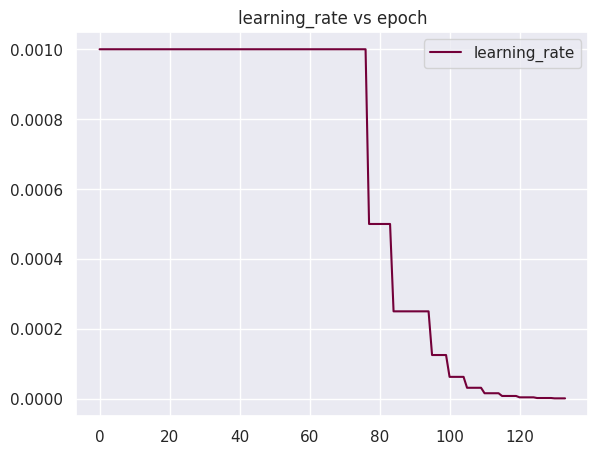

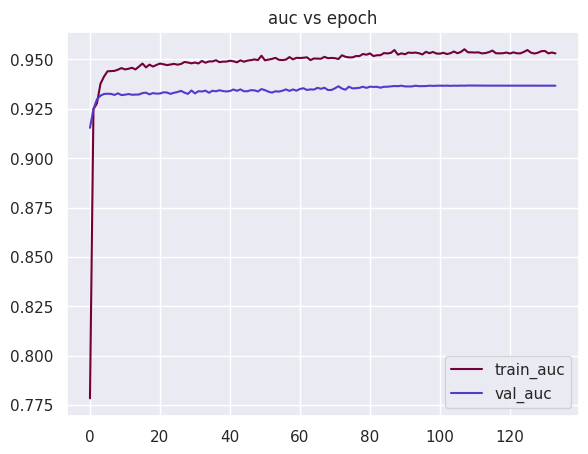

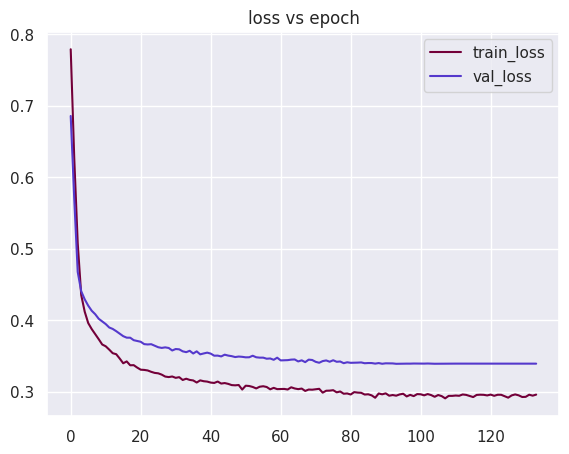

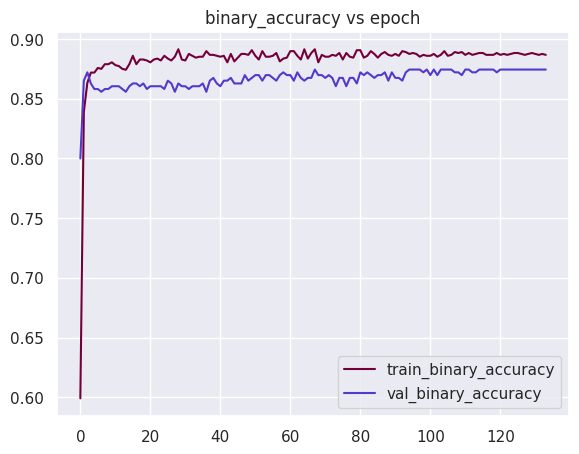

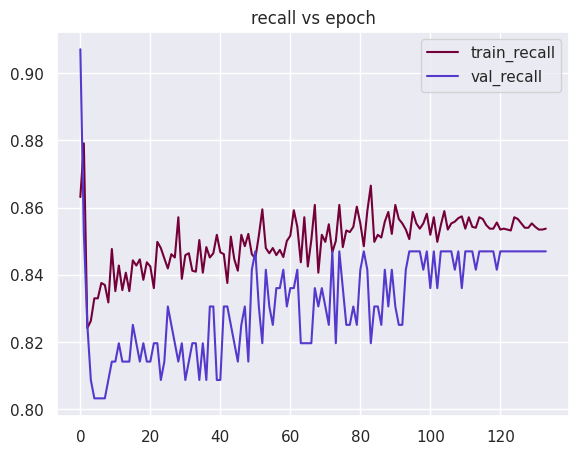

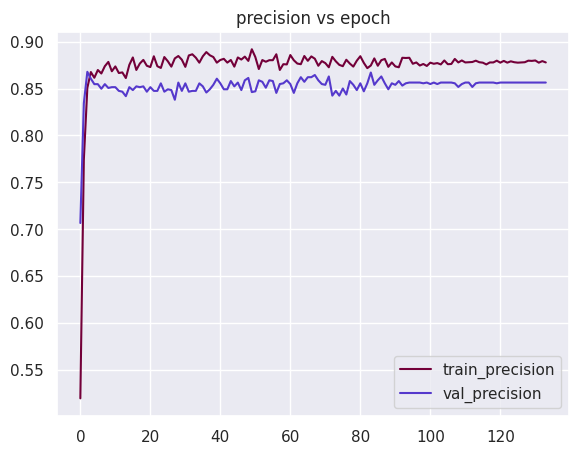

In [23]:

plot_dir = f'./plots/{run_name}/'
os.makedirs(plot_dir, exist_ok=True)
metrics_to_plot = [
    'learning_rate',
    'auc',
    'loss',
    'binary_accuracy',
    'recall',
    'precision']

metric_plots = {}
for mm in metrics_to_plot:
    metric_plots[mm] = plot_metric(history_df, mm);
    fig_path = os.path.join(plot_dir, f'{mm}_vs_epoch.png');
    print(fig_path)
    metric_plots[mm][0].savefig(fig_path);
                                 

    

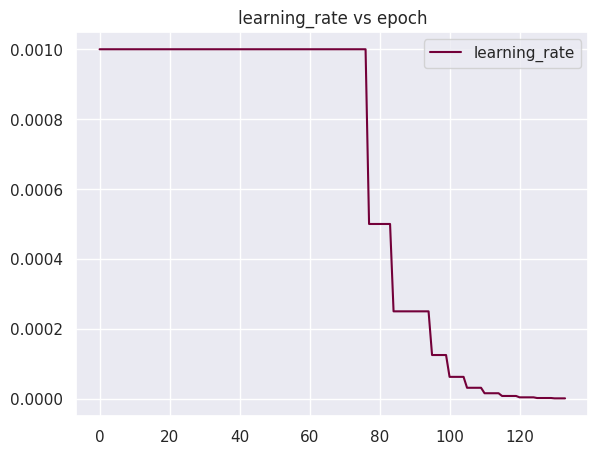

In [24]:
metric_plots[metrics_to_plot[0]][0]


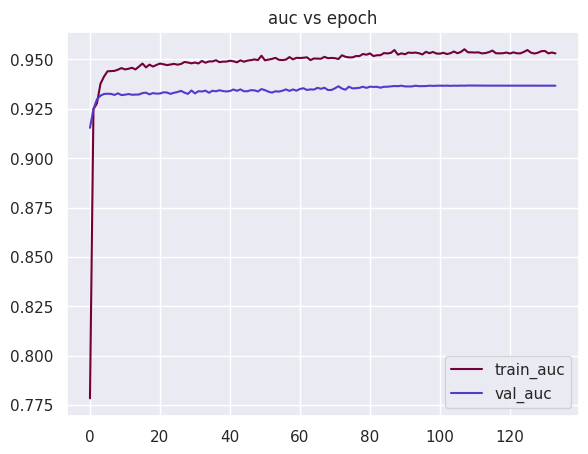

In [25]:
metric_plots[metrics_to_plot[1]][0]

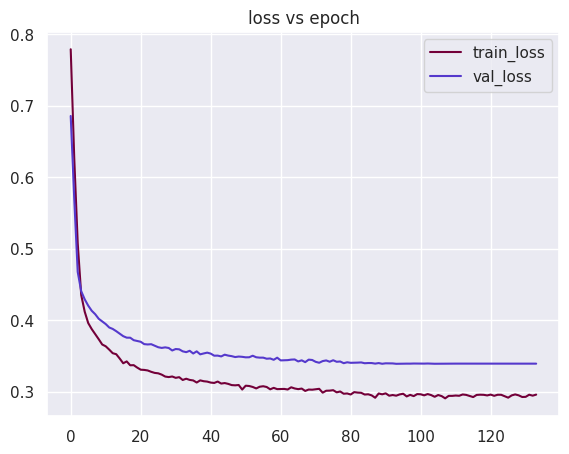

In [26]:
metric_plots[metrics_to_plot[2]][0]

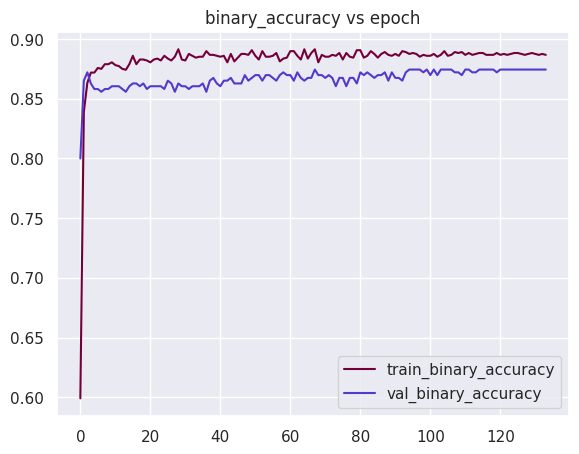

In [27]:
metric_plots[metrics_to_plot[3]][0]

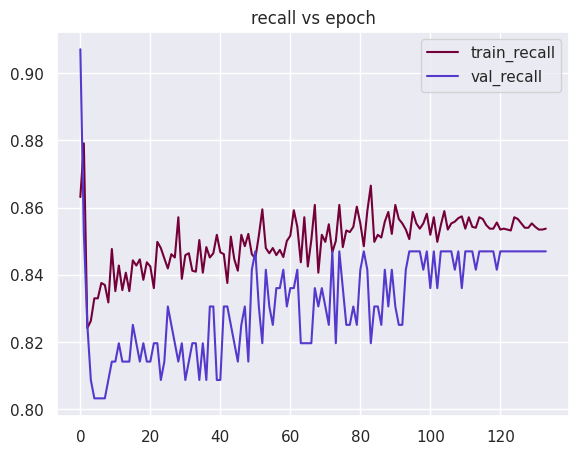

In [28]:
metric_plots[metrics_to_plot[4]][0]

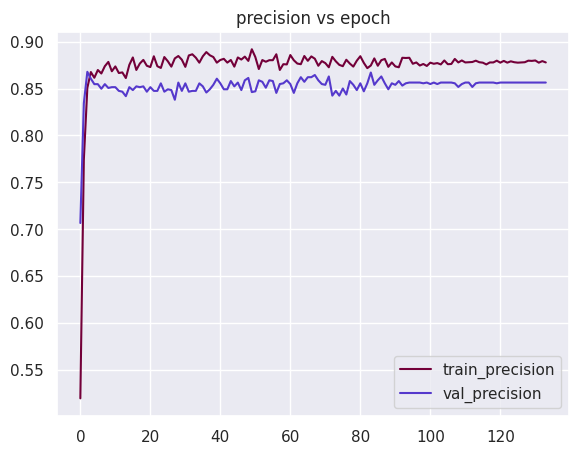

In [29]:
metric_plots[metrics_to_plot[5]][0]

In [30]:
# add plots as artifacts
val_metrics = [k for k in history_df.columns if k.startswith('val')]
best_epoch = history_df.loc[history_df.val_loss == np.min(history_df.val_loss)][['epoch'] + val_metrics].copy()

# best_epoch
rename = {k:f'best_epoch_{k}' for k in val_metrics}
rename['epoch'] = 'best_epoch'

best_stats = best_epoch\
    .rename(columns=rename)\
    .to_dict(orient='records')[0]
# best_stats


with mlflow.start_run(run_id=run_id) as mlflow_run:
#     for mm in metrics_to_plot:
#         # fig_path = os.path.join(plot_dir, f'{mm}_vs_epoch.png');
    mlflow.log_artifacts(plot_dir, artifact_path='training_plots')
    mlflow.log_metrics(best_stats)
        



🏃 View run crawling-auk-259 at: http://pistachio_mlflow:5000/#/experiments/312072479125166365/runs/39b70340312248829ed40b7344bace78
🧪 View experiment at: http://pistachio_mlflow:5000/#/experiments/312072479125166365


In [31]:
best_stats

{'best_epoch': 93,
 'best_epoch_val_auc': 0.9366939067840576,
 'best_epoch_val_binary_accuracy': 0.8720930218696594,
 'best_epoch_val_loss': 0.33913281559944153,
 'best_epoch_val_precision': 0.855555534362793,
 'best_epoch_val_recall': 0.8415300250053406}

In [32]:
print(model.metrics_names)
model.evaluate(valid_ds, return_dict=True)

['loss', 'compile_metrics']
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9266 - binary_accuracy: 0.8681 - loss: 0.3511 - precision: 0.8577 - recall: 0.7998


{'auc': 0.9367048740386963,
 'binary_accuracy': 0.8744186162948608,
 'loss': 0.33934882283210754,
 'precision': 0.8563535809516907,
 'recall': 0.8469945192337036}

## Model Evaluation



In [33]:
# load the best model from earlier
model = tf.keras.models.load_model(checkpoint_path)
valid_features = {k: valid_df[k].values for k in feature_columns}
valid_predictions = model.predict(valid_features)
valid_df['predicted_prob'] = valid_predictions
threshold = 0.5
valid_df['predicted_class'] = valid_df.predicted_prob.map(lambda x: 0 if x < threshold else 1)
# valid_df.head()
# valid_predictions[0:10]

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [34]:
model.evaluate(valid_ds, return_dict=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9265 - binary_accuracy: 0.8667 - loss: 0.3508 - precision: 0.8573 - recall: 0.7965 


{'auc': 0.9366939067840576,
 'binary_accuracy': 0.8720930218696594,
 'loss': 0.33913281559944153,
 'precision': 0.855555534362793,
 'recall': 0.8415300250053406}

In [35]:
# model.predict(valid_ds)

In [36]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
import scipy
import statsmodels
from statsmodels.stats.proportion import proportion_confint


import sys
def get_roc_results(predicted_probs: List[float], actual_classes: List[float]) -> Tuple[List[float],List[float],List[float]]:
    """get roc curve definition

    Args:
        predicted_probs (List[float]): predicted probabilities
        actual_classes (List[float]): actual binary labels

    Returns:
        Tuple[List,List,List]: fpr, tpr, thresholds
    """
    fpr, tpr, thresholds = roc_curve(actual_classes, predicted_probs)
    if thresholds[0] == float('inf'):
        thresholds[0] = sys.float_info.max

    return fpr, tpr, thresholds

#################################################################

def plot_roc_curve(fpr, tpr, thresholds, title: str="ROC curve", xlabel='False Positive Rate', ylabel: str='True Positive Rate') -> Tuple[mpl.figure.Figure, mpl.axes.Axes]:
    """_summary_

    Args:
        fpr (_type_): _description_
        tpr (_type_): _description_
        thresholds (_type_): _description_
        title (str, optional): _description_. Defaults to "ROC curve".
        xlabel (str, optional): _description_. Defaults to 'False Positive Rate'.
        ylabel (str, optional): _description_. Defaults to 'True Positive Rate'.

    Returns:
        Tuple[mpl.Figure, mpl.Axis]: _description_
    """
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    ax.plot(fpr, tpr, color=sns.xkcd_rgb['blurple'], label='roc curve')
    ax.plot([0.0, 1.0],[0.0, 1.0], color=sns.xkcd_rgb['merlot'], linestyle='--', label='random')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    # fig.show()
    return fig, ax
#################################################################
def get_confusion_matrix(predicted_classes, actual_classes, normalise=None):
    """get confusion matrix
    computes confusion matrix for binary classification

    Args:
        predicted_classes (_type_): _description_
        actual_classes (_type_): _description_
        normalise (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    matrix = confusion_matrix(actual_classes,predicted_classes, normalize=normalise)
    return matrix
#################################################################

def make_confusion_matrix_plot(
    predicted_classes,
    actual_classes,
    title:str = 'confusion matrix',
    xlabel: str='predicted class',
    ylabel: str='actual class',
    class_names: List[str] = None,
    normalise:str=None
    ):
    """ generate confusion matrix plot"""
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    ax.grid(False)
    # cmap = sns.color_palette("magma_r", as_cmap=True)
    cmap = sns.light_palette("indigo", as_cmap=True)

    # cmap = 'viridis'

    matrix = confusion_matrix(actual_classes,predicted_classes, normalize=normalise)
    ax.imshow(matrix, cmap=cmap)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(i,j,f'{matrix[i,j]}')
    # ax.plot([0.0, 1.0],[0.0, 1.0], color=sns.xkcd_rgb['merlot'], linestyle='--', label='random')
    labels = class_names if class_names else ['0','1']

    ax.set_xlim([-0.5, matrix.shape[0]- 0.5])
    ax.set_ylim([matrix.shape[0]- 0.5, -0.5])
    ax.set_xticks(np.arange(matrix.shape[0]))
    ax.set_yticks(np.arange(matrix.shape[0]))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    # ax.legend()
    # fig.show()
    return fig, ax
#################################################################
def make_precision_recall_plot(predicted_probs, actual_classes, title: str="Precision-Recall Curve", xlabel='Recall',ylabel: str='Precision',
                              positive_rate:float=None):
    """make a roc curve"""
    precision, recall, _ = precision_recall_curve(actual_classes, predicted_probs)
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    classifier_average_precision = average_precision_score(actual_classes, predicted_probs)
    ax.plot(recall, precision, color=sns.xkcd_rgb['blurple'], label=f'precision recall curve (average precision = {classifier_average_precision:0.3f}')
    if positive_rate:
        ax.plot([0.0, 1.0],[positive_rate, positive_rate], color=sns.xkcd_rgb['merlot'], linestyle='--', label=f'positive response rate = {positive_rate:0.3f}')

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend()
    # fig.show()
    return fig, ax
###########################################################

def make_prob_calibration_plot(predicted_probs, actual_classes, n_bins: int=20, alpha: float = 0.05, title:str = 'probability calibration'):
    """bin records, check that proportion of labels in each bin matches mean probability of that bin"""
    bins = pd.qcut(predicted_probs, n_bins, labels=False)
    df = pd.DataFrame({'probability':predicted_probs, 'class':actual_classes, 'bin':bins})
    df = df.sort_values(by='probability',ascending=False).reset_index(drop=True)
    agged = df.groupby('bin').agg(
        pred_prob=pd.NamedAgg('probability','mean'),
        pred_std=pd.NamedAgg('probability','std'),
        class_prob=pd.NamedAgg('class','mean'),
        class_sum=pd.NamedAgg('class','sum'),
        bin_size=pd.NamedAgg('class','count')
    )
    act_err_low, act_err_high = proportion_confint(agged.class_sum, agged.bin_size, method='wilson', alpha = alpha)
    z_low = scipy.stats.norm.ppf(alpha/2)
    z_high = scipy.stats.norm.ppf(1.0 - alpha/2)
    agged['pred_low'] =  -z_low*agged['pred_std']/np.sqrt(agged['bin_size']) # agged['pred_prob'] +
    agged['pred_high'] = z_high*agged['pred_std']/np.sqrt(agged['bin_size']) #+ agged['pred_prob'] +
    agged['actual_error_high'] = np.maximum(act_err_high  - agged.class_prob,0)
    agged['actual_error_low'] =  np.maximum(agged.class_prob - act_err_low,0)
    agged.loc[np.abs(agged.actual_error_high) < 1e-10, 'actual_error_high'] = 0


    # print(agged)
    # print(agged)
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1, 0.8, 0.8])
    ax.errorbar(
        agged.pred_prob,
        agged.class_prob,
        yerr=[agged.actual_error_low, agged.actual_error_high],
        xerr=[agged.pred_low,agged.pred_high],
        fmt='.',
        color=sns.xkcd_rgb['blurple'])
    ax.plot([0.0,1.0],[0.0,1.0],'--',label='ideal', color=sns.xkcd_rgb['dark blue'])
    ax.set_title(title)
    ax.set_xlabel('predicted probability')
    ax.set_ylabel('observed probabiilty')
    return fig, ax

In [37]:
valid_df.head()


,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class,predicted_prob,predicted_class
0,89379.0,1250.1960,480.1813,242.6649,0.8629,337.3438,0.9573,93365.0,0.7632,1.9788,0.7186,0.7025,0.0054,0.0027,0.4936,0.9766,0,0.340726,0
1,81632.0,1301.9969,445.4909,235.2594,0.8492,322.3928,0.9739,83820.0,0.7546,1.8936,0.6051,0.7237,0.0055,0.0029,0.5237,0.9917,1,0.523634,1
2,60865.0,1004.7420,405.0506,198.5787,0.8716,278.3806,0.9643,63117.0,0.7268,2.0397,0.7576,0.6873,0.0067,0.0033,0.4723,0.9635,0,0.009788,0
3,79711.0,1419.0811,488.5091,217.4910,0.8954,318.5768,0.9506,83855.0,0.7406,2.2461,0.4974,0.6521,0.0061,0.0027,0.4253,0.9552,0,0.016403,0
4,67869.0,1748.3650,403.0282,242.8356,0.7981,293.9617,0.8821,76939.0,0.6773,1.6597,0.2790,0.7294,0.0059,0.0036,0.5320,0.8829,1,0.179679,0


/tmp/ipykernel_16136/3059401343.py:22: RuntimeWarning: overflow encountered in cast
  thresholds[0] = sys.float_info.max


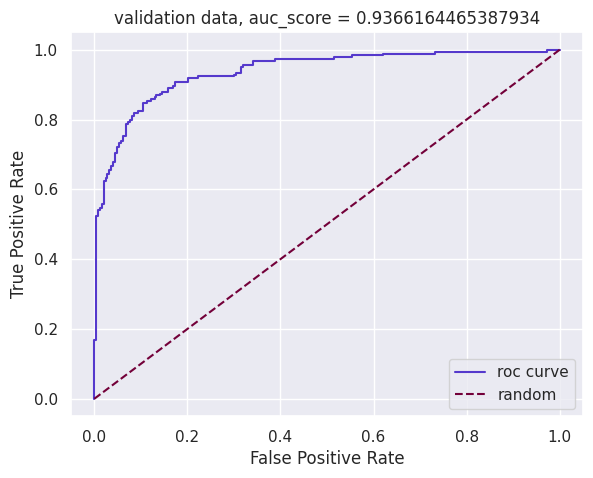

In [38]:
roc_results = get_roc_results(valid_df.predicted_prob, valid_df.Class)
valid_auc_score = roc_auc_score(valid_df.Class, valid_df.predicted_prob)
fig, ax = plot_roc_curve(*roc_results, title=f'validation data, auc_score = {valid_auc_score}');
roc_plot_path = os.path.join(plot_dir, 'roc_curve.png')
fig.savefig(roc_plot_path)



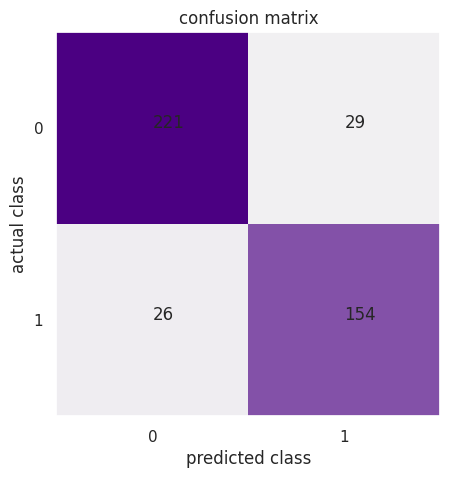

In [39]:
fig, ax = make_confusion_matrix_plot(valid_df.predicted_class, valid_df.Class)
confusion_plot_path = os.path.join(plot_dir, 'confusion_matrix.png')
fig.savefig(confusion_plot_path)

In [40]:
validation_metrics_path = './saved_model_validation_metrics.txt'
with open(validation_metrics_path,'w') as outfile:
    outfile.write(f'accuracy: {accuracy_score(valid_df.Class,valid_df.predicted_class)}\n')
    outfile.write(f'precision: {precision_score(valid_df.Class,valid_df.predicted_class)}\n')
    outfile.write(f'recall: {recall_score(valid_df.Class,valid_df.predicted_class)}\n')
    outfile.write(f'f1_score: {f1_score(valid_df.Class,valid_df.predicted_class)}\n')
    outfile.write(f'roc_auc_score: {valid_auc_score}\n')

print(open(validation_metrics_path,'r').read())


accuracy: 0.872093023255814
precision: 0.8555555555555555
recall: 0.8415300546448088
f1_score: 0.8484848484848485
roc_auc_score: 0.9366164465387934



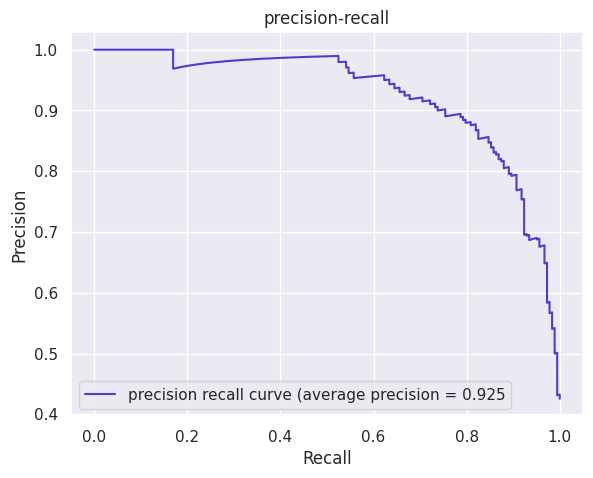

In [41]:
fig, ax = make_precision_recall_plot(valid_df.predicted_prob, valid_df.Class, title='precision-recall')
prec_rec_path = os.path.join(plot_dir,'precision_recall_curve.png')
fig.savefig(prec_rec_path)

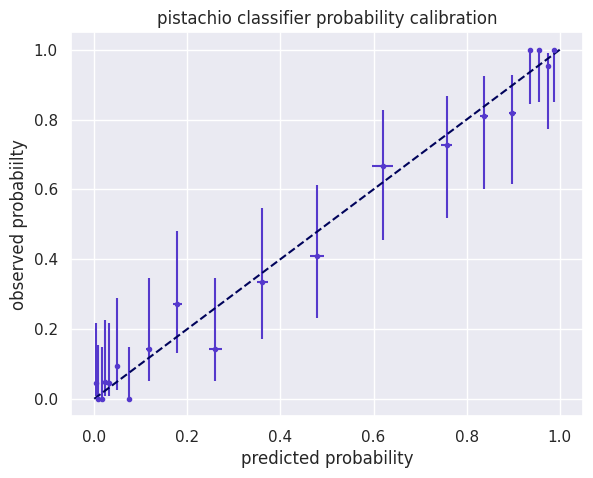

In [42]:
fig, ax = make_prob_calibration_plot(valid_df.predicted_prob, valid_df.Class, title='pistachio classifier probability calibration')
prob_cal_path = os.path.join(plot_dir,'probability_calibration.png')
fig.savefig(prob_cal_path)


## SHAP

In [43]:
import shap
def shap_wrapper(X):
    feature_dict = {k:X[:,i] for i,k in enumerate(feature_columns)}
    return model.predict(feature_dict).flatten()

shap_n_samples = 50
shap_explainer_samples = 50

data_shap = train_df.loc[:,feature_columns]
explainer = shap.KernelExplainer(shap_wrapper, data_shap.iloc[:shap_explainer_samples,:])
shap_values = explainer.shap_values(data_shap.iloc[shap_explainer_samples:shap_explainer_samples+shap_n_samples, :], nsamples=200)
# shap.force_plot(explainer.expected_value, shap_values, data_shap[237,:])




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━

In [44]:
shap_values.shape

(50, 16)

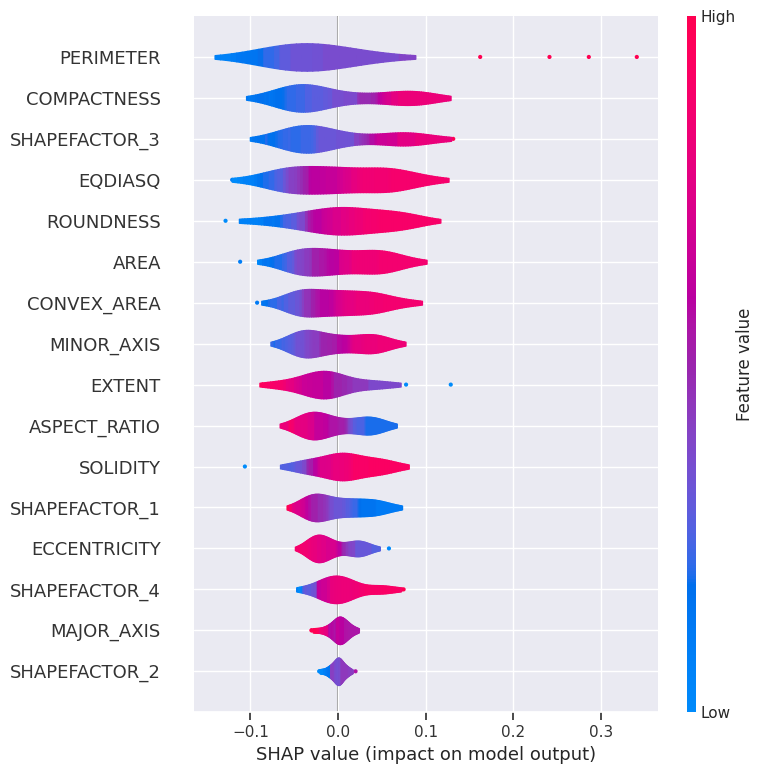

In [45]:
# shap.plots.scatter(explainer)
# shap.plots.bar(shap_values[0])
shap_violin_path = os.path.join(plot_dir,'shap_violin.png')
shap_bar_path = os.path.join(plot_dir,'shap_bar.png')

shap.summary_plot(
    shap_values, features=data_shap.iloc[50:100, :], feature_names=feature_columns, plot_type="violin", max_display=30, show=False)
plt.savefig(shap_violin_path)




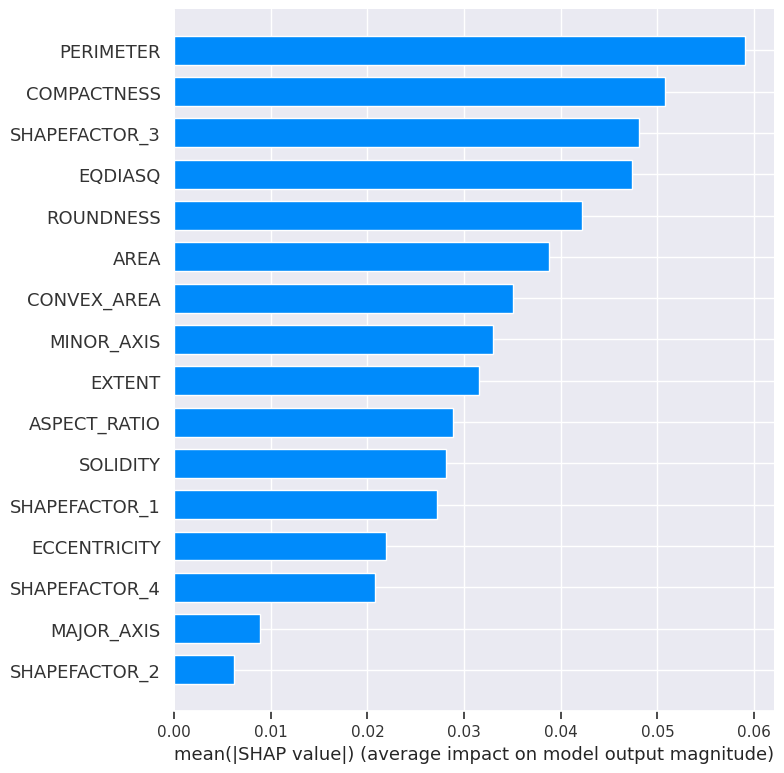

In [46]:
shap.summary_plot(
    shap_values, features=data_shap.iloc[50:100, :], feature_names=feature_columns, plot_type="bar", max_display=30, show=False)
plt.savefig(shap_bar_path)

In [47]:
with mlflow.start_run(run_id=run_id) as mlflow_run:
#     for mm in metrics_to_plot:
#         # fig_path = os.path.join(plot_dir, f'{mm}_vs_epoch.png');
    mlflow.log_artifact(roc_plot_path, artifact_path='evaluation_plots')
    mlflow.log_artifact(confusion_plot_path, artifact_path='evaluation_plots')
    mlflow.log_artifact(prob_cal_path, artifact_path='evaluation_plots')
    mlflow.log_artifact(prec_rec_path, artifact_path='evaluation_plots')

    mlflow.log_artifact(validation_metrics_path)
    mlflow.log_artifact(shap_bar_path, artifact_path='evaluation_plots')
    mlflow.log_artifact(shap_violin_path, artifact_path='evaluation_plots')
    

    


    
    # mlflow.log_metrics(best_stats)

🏃 View run crawling-auk-259 at: http://pistachio_mlflow:5000/#/experiments/312072479125166365/runs/39b70340312248829ed40b7344bace78
🧪 View experiment at: http://pistachio_mlflow:5000/#/experiments/312072479125166365
